In [2]:
# Install qiskit library
%pip install qiskit
# Install pylatex in order to make the plots work
%pip install pylatexenc

     |████████████████████████████████| 6.1 MB 4.0 MB/s 
     |████████████████████████████████| 17.9 MB 114 kB/s 
     |████████████████████████████████| 236 kB 73.7 MB/s 
     |████████████████████████████████| 207 kB 76.2 MB/s 
     |████████████████████████████████| 2.1 MB 27.2 MB/s 
     |████████████████████████████████| 1.4 MB 42.2 MB/s 
     |████████████████████████████████| 634 kB 49.5 MB/s 
     |████████████████████████████████| 52 kB 2.0 MB/s 
     |████████████████████████████████| 49 kB 8.0 MB/s 
     |████████████████████████████████| 943 kB 34.1 MB/s 
     |████████████████████████████████| 38.2 MB 21 kB/s 
     |████████████████████████████████| 3.5 MB 37.8 MB/s 
     |████████████████████████████████| 6.3 MB 21.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.31.0-py3-none-any.whl size=11728 sha256=1e84fa48b34a9763740af95639c7fec8a111fba1ec1b3a49ecb108a7437425bc
  Stored in directory: /root/.cache/pip/wheels/29/dd/b2/1fe1a9ac92aaf75b267d893ae27329ea229f292a29301

In [96]:
# Import numpy, matplotlib, qiskit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.visualization import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from math import *

# Definition of SPIN correlation with qbits array format in quiskit for more clarity
SPIN_DOWN = [1,0]
SPIN_UP = [0,1]

## Circuits

Here we define the functions which return the circuits

In [97]:
def Nodo_exec_counts(circ, shots=1000):
  """
  Get the get_count() object of quiskit when execute specific number of shots.
  Executed in 'qasm_simulator' backend.
  Args:
    circ: QuantumCircuit to execute
    shots: number of executions, default=1000

  Return:
    get_count() object of quiskit
  """
  backend = BasicAer.get_backend('qasm_simulator') # the device to run on
  result = execute(circ, backend, shots=shots).result().get_counts()
  #print(result)
  return result

def Nodo_exec(circ):
  """
  Get the qbit value in output when executed 1 shot.
  Executed in 'qasm_simulator' backend.
  Args:
    circ: QuantumCircuit to execute

  Return:
    SPIN_DOWN or SPIN_UP matrix
  """
  backend = BasicAer.get_backend('qasm_simulator') # the device to run on
  result = execute(circ, backend, shots=1).result().get_counts()
  #print(result)
  return SPIN_DOWN if "0" in result and result["0"]==1 else SPIN_UP

### Ising Without Magnetism

In [98]:
def ISING_GATE():
  """
  Define the ISING circuit without setting the inputs for be used as sub_circuit
  or gate in others circuits

  Return:
    ISING circuite

  """
  circ = QuantumCircuit(5, name="ISING") 
  #circ.initialize(SPIN_DOWN, 3)

  circ.mcx([0,1,2],3)
  #######
  circ.barrier()
  circ.x(0)
  circ.x(1)
  circ.x(2)
  circ.mcx([0,1,2],3)
  circ.x(0)
  circ.x(1)
  circ.x(2)
  circ.barrier()
  ######
  circ.x(3)
  circ.cx(3,0)
  circ.x(3)
  circ.barrier()
  #######
  circ.ccx(3,4,0)
  return circ

def ISING(S,A,B,P):
  """
  Define the ISING circuit and setting the inputs for be executed
  or gate in others circuits. Depends on the Temperature.

  ARGS:
    S: state of spin to execute and measure
    A: state of the left neighbour
    B: state of the right neighbour
    P: [sqrt(1-P), sqrt(P)]. P depends on T

  Return:
    ISING circuite with initial states defines

  """
  circ = QuantumCircuit(5, 1, name="ISING_GATE") 
  circ.initialize(SPIN_DOWN, 3)
  circ.initialize(S, 0)
  circ.initialize(A,1)
  circ.initialize(B,2)
  circ.initialize(P[0],4)

  circ.mcx([0,1,2],3)
  #######
  circ.barrier()
  circ.x(0)
  circ.x(1)
  circ.x(2)
  circ.mcx([0,1,2],3)
  circ.x(0)
  circ.x(1)
  circ.x(2)
  circ.barrier()
  ######
  circ.x(3)
  circ.cx(3,0)
  circ.x(3)
  circ.barrier()
  #######
  circ.ccx(3,4,0)
  circ.measure(0, 0)
  return circ

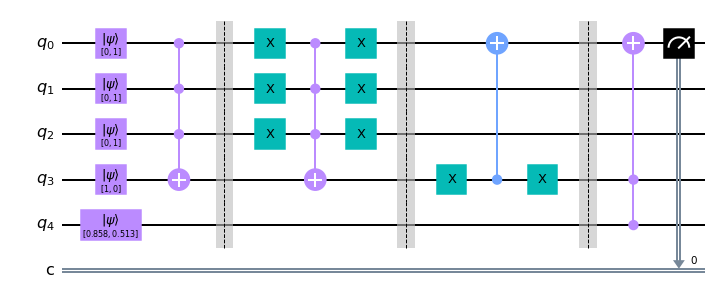

In [99]:
P = exp(-4/3)
P_calc = [sqrt(1-P), sqrt(P)]
circ = ISING(SPIN_UP,SPIN_UP,SPIN_UP, [P_calc])
circ.draw(output='mpl')

{'1': 708, '0': 292}


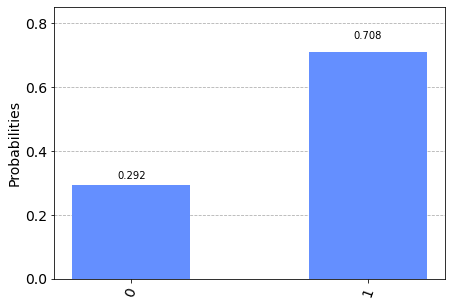

In [100]:
result = Nodo_exec_counts(circ)
print(result)
plot_histogram(result)

### Ising Magnetism

In [101]:
def getP_i(T,h):
  """
  Calculate the hopping probabilities

  ARGS:
    T: Temperature
    h: Magnetic field

  Return:
    P1 = min(1, np.exp(-1*(4-2*h)/T))
    P2 = min(1, np.exp (  (4-2*h)/T  ))
    P3 = np.exp(-2*h/T)
    P4 = np.exp(-1*(4+2*h)/T)

  """
  p1 = min(1, np.exp(-1*(4-2*h)/T))
  p2 = min(1, np.exp (  (4-2*h)/T  ))
  p3 = np.exp(-2*h/T)
  p4 = np.exp(-1*(4+2*h)/T)
  P1 = [np.sqrt(1-p1), np.sqrt(p1)]
  P2 = [np.sqrt(1-p2), np.sqrt(p2)]
  P3 = [np.sqrt(1-p3), np.sqrt(p3)]
  P4 = [np.sqrt(1-p4), np.sqrt(p4)]
  return P1, P2, P3, P4

In [102]:
def ISINH(S,A,B,P1,P2,P3,P4):
  """
  Define the ISINH circuit and setting the inputs for be executed
  or gate in others circuits. Depend on the Temperature and Magnetic field 

  ARGS:
    S: state of spin to execute and measure
    A: state of the left neighbour
    B: state of the right neighbour
    P1 = min(1, np.exp(-1*(4-2*h)/T))
    P2 = min(1, np.exp (  (4-2*h)/T  ))
    P3 = np.exp(-2*h/T)
    P4 = np.exp(-1*(4+2*h)/T)

  Return:
    ISINH circuite with initial states defines

  """
  circ = QuantumCircuit(9, 1) 
 
  circ.initialize(S, 0)
  circ.initialize(A,1)
  circ.initialize(B,2)
  circ.initialize(SPIN_DOWN, 3)
  circ.initialize(SPIN_DOWN, 4)
  
  circ.initialize(P1,5)
  circ.initialize(P2,6)
  circ.initialize(P3,7)
  circ.initialize(P4,8)
  
  circ.mcx([0,1,2],3)
  
  circ.x(0)
  circ.x(1)
  circ.x(2)
  circ.mcx([0,1,2],3)
  circ.x(0)
  circ.x(1)
  circ.x(2)
  circ.barrier()
  ######
  circ.x(1)
  circ.mcx([0,1,2], 4)
  circ.x(1)
  circ.x(2)
  circ.mcx([0,1,2], 4)
  circ.x(2)
  circ.barrier()
  ######
  circ.x(2)
  circ.mcx([2,3,5],0)
  circ.x(2)
  circ.mcx([2,3,8],0)

  circ.barrier()
  ######

  circ.mcx([4,7], 0)

  circ.x(1)
  circ.x(2)
  circ.x(3)
  circ.mcx([1,2,3,6], 0)
  circ.x(1)
  circ.x(2)
  circ.x(3)
  circ.barrier()

  ######

  circ.x(3)
  circ.x(4)
  circ.mcx([2,3,4],0)
  circ.x(3)
  circ.x(4)

  circ.x(3)
  circ.x(4)
  circ.mcx([1,3,4],0)
  circ.x(3)
  circ.x(4)

  circ.x(3)
  circ.x(4)
  circ.mcx([1,2,3,4],0)
  circ.x(3)
  circ.x(4)


  circ.barrier()
  ######
  circ.measure(0, 0)
  return circ

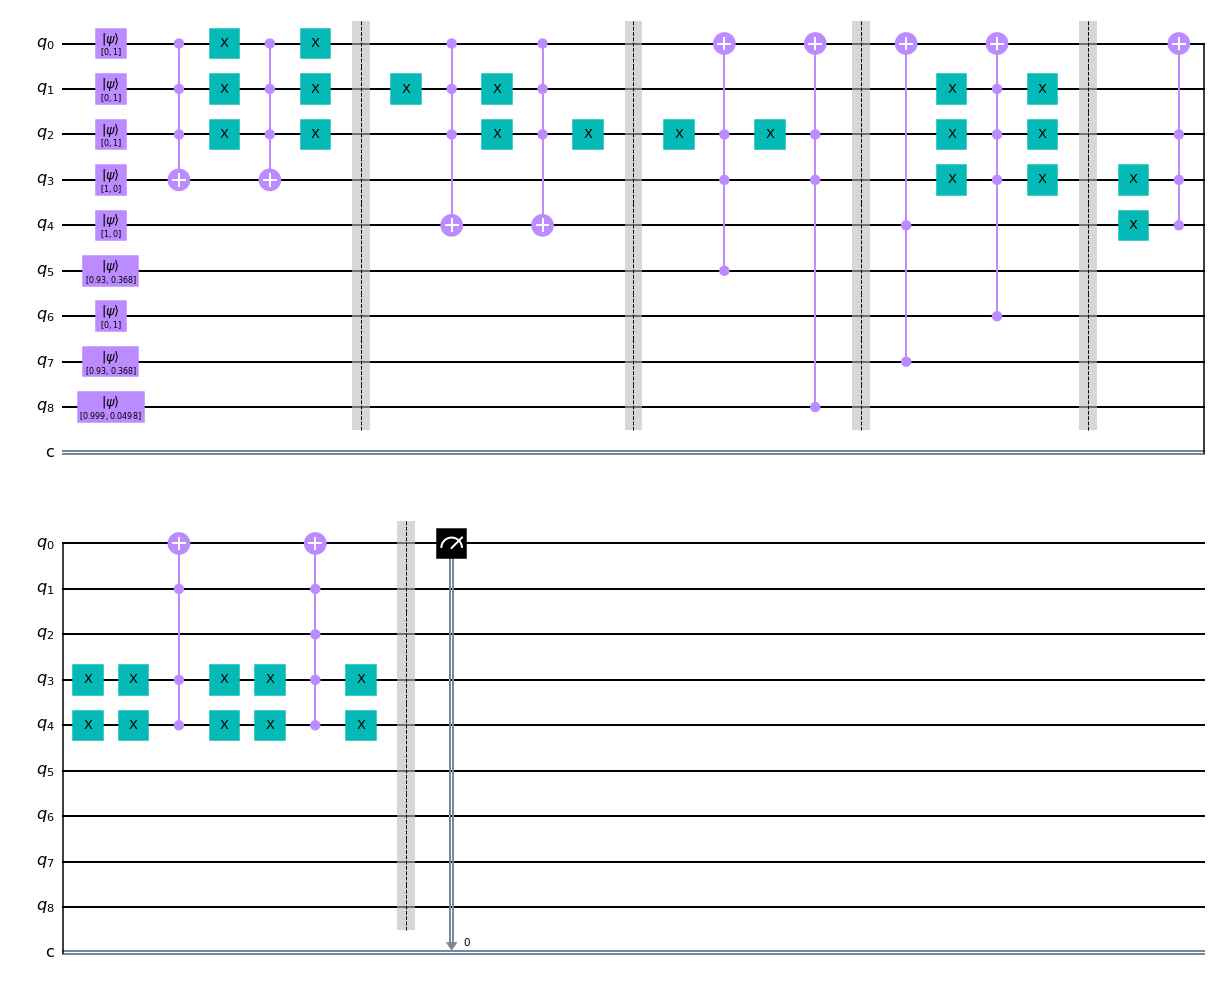

In [103]:
P1,P2,P3,P4 = getP_i(T=1,h=1)
circ = ISINH(SPIN_UP,SPIN_UP,SPIN_UP,P1,P2,P3,P4)
circ.draw(output='mpl')

{'1': 995, '0': 5}


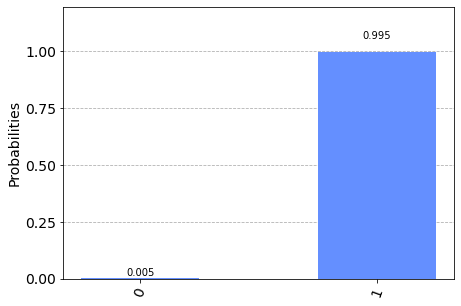

In [104]:
result = Nodo_exec_counts(circ)
print(result)
plot_histogram(result)

### Isign One Measure

In [105]:
def ISING_one_measure(S,A,B,P,M,generations=1):
  """
  Define ISING circuit design specifically to 4 spins and avoid measure in each 
  generation only in the end. We define a cyclic circuite which

  ARGS:
    S: state of spin to execute and measure
    A: state of the left neighbour
    B: state of the right neighbour
    P1 = min(1, np.exp(-1*(4-2*h)/T))
    P2 = min(1, np.exp (  (4-2*h)/T  ))
    P3 = np.exp(-2*h/T)
    P4 = np.exp(-1*(4+2*h)/T)

  Return:
    ISINH circuite with initial states defines

  """
  circ = QuantumCircuit(6, 4, name="ISING_no_measure") 
 
  circ.initialize(S, 0)
  circ.initialize(A,1)
  circ.initialize(B,2)
  circ.initialize(SPIN_DOWN, 3)
  circ.initialize(P,4)
  circ.initialize(M,5)
  
  for i in range(generations):
    ising = ISING_GATE().to_instruction()
    circ.append(ising, [0,1,2,3,4])
    #BLOQUE DE ISING
    circ.swap(0,5)
    circ.swap(1,2)
    circ.append(ising, [0,1,2,3,4])
    #BLOQUE DE ISING
    circ.swap(0,1)
    circ.swap(1,2)
    circ.swap(1,5)
    circ.append(ising, [0,1,2,3,4])
    #BLOQUE ISING
    circ.swap(1,2)
    circ.swap(0,5)
    circ.append(ising, [0,1,2,3,4])
    #BLOQUE ISING
    circ.swap(0,2)
    circ.swap(1,2)
    circ.swap(2,5)

  ###### Hay que hacer un measure de todos los qubits, importante meterlo al final
  circ.measure(0, 0)
  circ.measure(1, 3)
  circ.measure(2, 1)
  circ.measure(5, 2)
  return circ

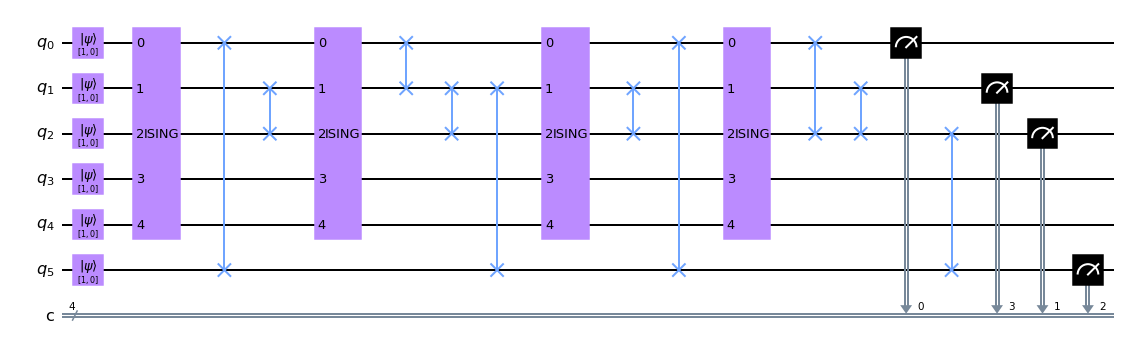

In [106]:
circ = ISING_one_measure(SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN, generations=1)
circ.draw(output='mpl')

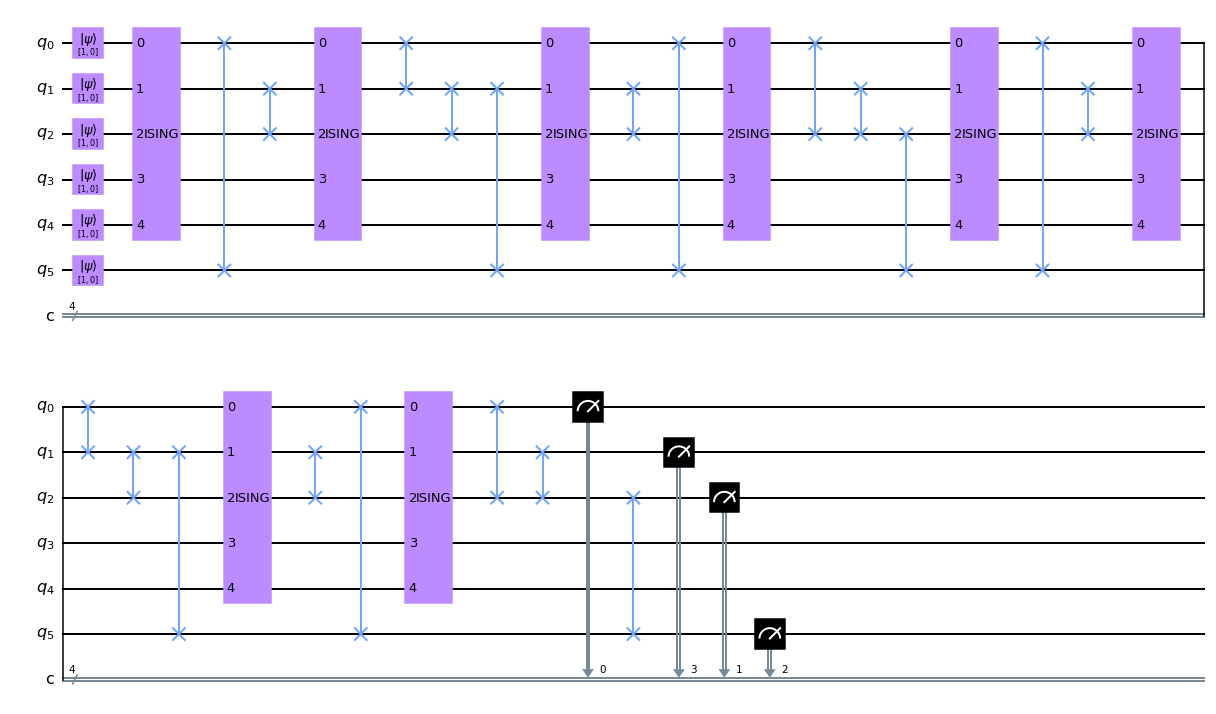

In [107]:
circ = ISING_one_measure(SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN, generations=2)
circ.draw(output='mpl')

## Ising Loop Implementations

In [108]:
# Auxiliar function to print spin as rows
def qbit_to_arrow(S):
  """
  Print qbit or spin in arrow unicode format

  ARGS:
    S: qbit or spin array format. Ej: [0,0]

  Return:
    Unicode arrow

  Raise:
    Exception when the spin is not [0,1] or [1,0]
  """
  arrows = []
  for i in S:
    if i == SPIN_UP:
      arrows.append(u"\u2191")
    elif i == SPIN_DOWN:
      arrows.append(u"\u2193")
    else:
      print(i)
      raise Exception("Not SPIN_DOWN or SPIN_UP")

  return arrows

### Ising 1D

#### Without Magnetism

In [109]:
def set_neighbours(S):
  """
  Return:
    As: Left neightbour
    As: Left neightbour
  """
  As = left_neighbours(S)
  Bs = right_neighbours(S)

  return As, Bs

def left_neighbours(Ss):
  left = []
  for i in range(len(Ss)):
    left.append(Ss[(i-1)%len(Ss)])

  return left

def right_neighbours(Ss):
  right = []
  for i in range(len(Ss)):
    right.append(Ss[(i+1)%len(Ss)])

  return right

In [111]:
def generation_update(circuit_def, Ss, P):
  As, Bs = set_neighbours(Ss)
  return {i: circuit_def(Ss[i], As[i], Bs[i], P) for i in range(len(Ss))}

def Ising(T, Ss=[SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN], generations=10):

  As, Bs = set_neighbours(Ss)

  #print("As Bs", As, Bs)

  P = exp(-4/T)
  P_calc = [sqrt(1-P), sqrt(P)]

  circuit_def = ISING

  circuitos = generation_update(circuit_def, Ss, [P_calc])

  spin = []
  #print('Spin Incial:', Ss)
  for i in range(generations):
    #print("Generation", i)
    for j in range(0,len(Ss),2):
      Ss[j] = Nodo_exec(circuitos[j])
    circuitos = generation_update(circuit_def, Ss, [P_calc])

    #print('\tSpin:', Ss)

    for j in range(1,len(Ss),2):
      Ss[j] = Nodo_exec(circuitos[j])
    circuitos = generation_update(circuit_def, Ss, [P_calc])

    #print('\tSpin:', Ss)

    spin.append((sum([k[1] for k in Ss])*1 - sum([k[0] for k in Ss])) / len(Ss))

  return Ss, sum(spin)/generations

  
def Ising_with_warmup(T, Ss=[SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN], num_warmup=10, generations=10):
  Ss, avg_up = Ising(T, Ss, generations=num_warmup) # calentamiento
  Ss, avg_up = Ising(T, Ss, generations=generations)
  return Ss, avg_up

In [112]:
S = [SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN]
spins, avg_up = Ising_with_warmup(T=1, Ss=S, num_warmup=50, generations=50)

In [113]:
print(spins)
print(qbit_to_arrow(spins))
print('AVG SPIN_UP:', avg_up)

[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑']
AVG SPIN_UP: 0.25


In [57]:
S = [SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN]
avg_up_vec = []
Ts = np.linspace(0.1,2,20)
for i in Ts:
  _ , avg_up = Ising_with_warmup(T=i, Ss=S, num_warmup=50, generations=50)
  avg_up_vec.append(avg_up)

As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Inc

Text(0.5, 1.0, 'Spin dependence of temperature')

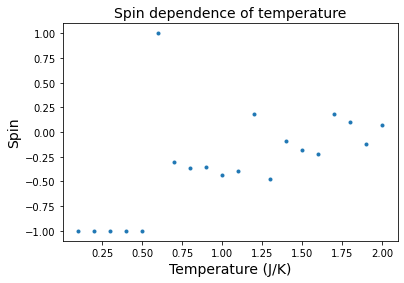

In [78]:
plt.plot(Ts, avg_up_vec, '.')
plt.xlabel("Temperature (J/K)", fontsize = 14)
plt.ylabel("Spin", fontsize = 14)
plt.title("Spin dependence of temperature", fontsize = 14)

#### With Magnetism

In [114]:
def generation_update_mag(circuit_def, Ss, P):
  As, Bs = set_neighbours(Ss)
  return {i: circuit_def(Ss[i], As[i], Bs[i], P[0], P[1], P[2], P[3]) for i in range(len(Ss))}

In [121]:
def Ising_Magnetic(h, T, Ss=[SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN], generations=10):

  As, Bs = set_neighbours(Ss)

  #print("As Bs", As, Bs)

  P1, P2, P3, P4 = getP_i(T,h)

  P = [P1, P2, P3, P4]

  circuit_def = ISINH

  circuitos = generation_update_mag(circuit_def, Ss, P)

  spin = []
  #print('Spin Incial:', Ss)
  for i in range(generations):
    #print("Generation", i)
    for j in range(0,len(Ss),2):
      Ss[j] = Nodo_exec(circuitos[j])
    circuitos = generation_update_mag(circuit_def, Ss, P)

    #print('\tSpin:', Ss)

    for j in range(1,len(Ss),2):
      Ss[j] = Nodo_exec(circuitos[j])
    circuitos = generation_update_mag(circuit_def, Ss, P)

    #print('\tSpin:', Ss)

    spin.append((sum([k[1] for k in Ss])*1 - sum([k[0] for k in Ss])) / len(Ss))

  return Ss, sum(spin)/generations

def Ising_Magnetic_with_warmup(h, T, Ss=[SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN], num_warmup=5, generations=10):
  Ss, _ = Ising_Magnetic(h, T, Ss, generations=num_warmup)
  Ss, avg_up = Ising_Magnetic(h, T, Ss, generations=generations)
  return Ss, avg_up

In [118]:
spins, avg_up = Ising_Magnetic(h=1, T=1, Ss=[SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN], generations=10)

As Bs [[1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0]]


In [119]:
print(spins)
print(qbit_to_arrow(spins))
print('AVG SPIN_UP:', avg_up)

[[0, 1], [0, 1], [0, 1], [0, 1]]
['↑', '↑', '↑', '↑']
AVG SPIN_UP: 0.95


In [122]:
spins, avg_up = Ising_Magnetic_with_warmup(h=1, T=1, Ss=[SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN], num_warmup=5, generations=10)

In [124]:
print(spins)
print(qbit_to_arrow(spins))
print('AVG SPIN_UP:', avg_up)

[[0, 1], [0, 1], [0, 1], [0, 1]]
['↑', '↑', '↑', '↑']
AVG SPIN_UP: 1.0


In [91]:
#We use low temperatures to see the how the function becomes step at h=0
S = [SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN,SPIN_DOWN]
T_vec = [0.1, 1, 5]
h_num = 10 
h_vec = np.linspace(0.3, 2, h_num)
avg_spin_vec = np.zeros([len(T_vec),h_num])
for i in range(len(T_vec)):
  for j in range(h_num):
    _ , avg_spin_vec[i, j] = Ising_Magnetic_with_warmup(h_vec[j], T_vec[i], Ss=S, 
                                                 num_warmup=5, generations=5)

As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]] [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Spin Incial: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
As Bs 

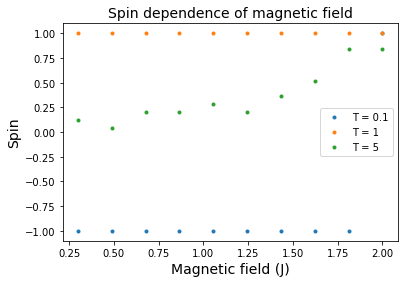

In [94]:
for i in range(len(T_vec)):
  plt.plot(h_vec, avg_spin_vec[i, :], '.')
plt.xlabel("Magnetic field (J)", fontsize = 14)
plt.ylabel("Spin", fontsize = 14)
plt.title("Spin dependence of magnetic field", fontsize = 14)
plt.legend(["T = 0.1", "T = 1", "T = 5"])